# Implementation of Spiral Architecture

Spiral architecture has been introduced by Sheridan in 

- [_Spiral Architecture for Machine Vision_](https://opus.lib.uts.edu.au/research/handle/2100/280), PhD thesis
- [_Pseudo-invariant image transformations on a hexagonal lattice_](http://www.sciencedirect.com/science/article/pii/S0262885600000366), P. Sheridan, T. Hintz, and D. Alexander, Image Vis. Comput. 18, 907 (2000).

The implementation with hyperpels that we use in the following is presented in 

- [_A New Simulation of Spiral Architecture_](http://ww1.ucmss.com/books/LFS/CSREA2006/IPC8173.pdf), X. He, T. Hintz, Q. Wu, H. Wang, and W. Jia, Proceedings of International Conference on Image Processing, Computer Vision, and Pattern Recognition (2006).
- [_Hexagonal structure for intelligent vision_](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=1598543&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F10652%2F33619%2F01598543), X. He and W. Jia, in Proc. 1st Int. Conf. Inf. Commun. Technol. ICICT 2005 (2005), pp. 52–64.

## Inizializations and auxiliary functions

In [2]:
import numpy as np
from numpy import fft
from numpy import linalg as LA
from scipy import ndimage
# from scipy import linalg 
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os

In [3]:
%matplotlib inline

In [4]:
# ALPHABET = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
ALPHABET = "0123456"

def base7_encode(num, alphabet=ALPHABET):
    """Encode a number in Base X

    `num`: The number to encode
    `alphabet`: The alphabet to use for encoding
    """
    if (num == 0):
        return alphabet[0]
    arr = []
    base = len(alphabet)
    while num:
        rem = num % base
        num = num // base
        arr.append(alphabet[rem])
    arr.reverse()
    return int(''.join(arr))

def base7_decode(string, alphabet=ALPHABET):
    """Decode a Base X encoded string into the number

    Arguments:
    - `string`: The encoded string
    - `alphabet`: The alphabet to use for encoding
    """
    base = len(alphabet)
    strlen = len(string)
    num = 0

    idx = 0
    for char in string:
        power = (strlen - (idx + 1))
        num += alphabet.index(char) * (base ** power)
        idx += 1

    return num

In [5]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

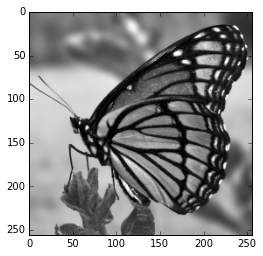

In [6]:
example =  1 - rgb2gray(plt.imread('./test-images/butterfly.png'))
plt.imshow(example,cmap=cm.binary)

## Oversampling

We start with a $M\times M$ image, and transform it to a $7M \times 7M$ one

In [7]:
def oversampling(image, factor = 7):
    old_shape = image.shape
    new_shape = (factor*old_shape[0], factor*old_shape[1])
    new_image = np.zeros(new_shape)
    for i in range(old_shape[0]):
        for j in range(old_shape[1]):
            new_image[factor*i:factor*i+factor,factor*j:factor*j+factor] = image[i,j]*np.ones((factor,factor))
    return new_image

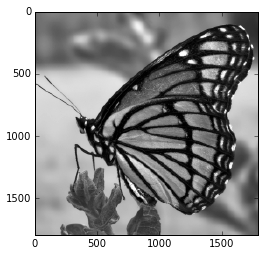

In [8]:
oversampled_example = oversampling(example)
plt.imshow(oversampled_example,cmap = cm.binary)

## Rows/Columns hexagonal grid

The grid where we place the hyperpel is centered in the center of the central hyperpel.

In [9]:
# Distance between centers of adjacent hexagons
# with the hyperpel
# 
# o o x x x x x o o
# o x x x x x x x o
# o x x x x x x x o
# x x x x x x x x x
# x x x x x x x x x 
# o x x x x x x x o
# o x x x x x x x o
# o o x x x x x o o

dist = np.sqrt(65)

# The centered hyperpel
hyperpel = np.array([\
                [-1,4],[0,4],[1,4],[2,4],[3,4],\
                [-2,3],[-1,3], [0,3], [1,3], [2,3], [3,3], [4,3],\
                [-2,2],[-1,2], [0,2], [1,2], [2,2], [3,2], [4,2],\
                [-3,1],[-2,1],[-1,1], [0,1], [1,1], [2,1], [3,1], [4,1],[5,1],\
                [-3,0],[-2,0],[-1,0], [0,0], [1,0], [2,0], [3,0], [4,0],[5,0],\
                [-2,-1],[-1,-1], [0,-1], [1,-1], [2,-1], [3,-1], [4,-1],\
                [-2,-2],[-1,-2], [0,-2], [1,-2], [2,-2], [3,-2], [4,-2],\
                [-1,-3], [0,-3], [1,-3], [2,-3], [3,-3]])

for i in range(56):
    hyperpel[i] = [hyperpel[i,1],hyperpel[i,0]]

In [10]:
# This function returns the coordinates of an hexagon, given
# its position with row/column, for the above hyperpel
# and assuming an oversampled image by a factor of 7

# Here the hex of position [0,1] is right UP w.r.t. the central hexagon

def hex2cartesian(row, column):
    x = 7 * column
    # even column
    if column % 2 == 0:
        y = 8*row
    # odd row
    else:
        y = 4 + 8*row
        
    return x,y

In [11]:
# This function returns the coordinates of the points of 
# the hyperpel corresponding to the hexagon of given
# row/column positions

# Here, we assume the center of the [0,0] hyperpel to be at the 
# intersection of the 2 rightmost pixels of the central 4,
# while the "center of the image" will be as in picture:
# o o x x x x x o o
# o x x x x x x x o
# o x x x x x x x o
# x x x x x x x x x
# x x x C x x x x x 
# o x x x x x x x o
# o x x x x x x x o
# o o x x x x x o o

def center_hyperpel(image,column,row):
    # The center of the image are 4 pixels, we denote as center
    # the one left-down:
    #
    #  O O
    #  C O
    cent_y = int(np.floor(float(image.shape[0])/2))
    cent_x = int(np.floor(float(image.shape[1])/2))
    
    h_x,h_y = hex2cartesian(row,column)
    
    # We return the translated one
    return hyperpel + [cent_y,cent_x] + [h_y,h_x]

The following shows that indeed the hyperpels are generated correctly

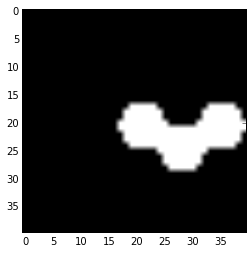

In [12]:
ciao = np.ones((40,40))
hp = center_hyperpel(ciao,0,0)
for i in range(56):
    ciao[hp[i,0],hp[i,1]] =0
hp = center_hyperpel(ciao,1,0)
for i in range(56):
    ciao[hp[i,0],hp[i,1]] =0
hp = center_hyperpel(ciao,2,0)
for i in range(56):
    ciao[hp[i,0],hp[i,1]] =0
plt.imshow(ciao,cmap=cm.binary)

In [13]:
# This function returns the value of the hexagonal pixel,
# depending on the values of the oversampled image
# given its row/column position, for the above hyperpel

def hex_value(oversampled_image,row,column):
    hp = center_hyperpel(oversampled_image,row,column)
    val = 0.
    for i in range(56):
        val += oversampled_image[hp[i,0],hp[i,1]]
    
    return val/56

In [14]:
# This function returns the grid for the hex row/column representation
# given the ORIGINAL size of the image

def hex_grid(image_size = 256):
    up_rows = down_rows = int(np.floor((7*image_size/2-4)/8))
    left_columns = int(np.floor((7*image_size/2-4)/9))
    right_columns = int(np.floor((7*image_size/2-5)/9))
    
    # My computations suggested +1, but up to
    # +22 works without catching any exception
    return np.zeros((up_rows+down_rows+25, left_columns+right_columns+25))

In [15]:
# This function, given an image, fills the corresponding hex grid

def image2hex(image):
    original_size = image.shape[0]
    oversampled_image = oversampling(image)
    grid = hex_grid(original_size)
    
    hex_center = [(grid.shape[0]-1)/2,(grid.shape[1]-1)/2]
    
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            try:
                grid[i,j] = hex_value(oversampled_image,i-hex_center[0], j-hex_center[1])
            except IndexError:
                continue

    return grid

In [16]:
def hex2image(grid, image_size=256):
    image = np.zeros((image_size*7,image_size*7))
    hex_center = [(grid.shape[0]-1)/2,(grid.shape[1]-1)/2]
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            hp = center_hyperpel(image,i-hex_center[0],j-hex_center[1])
            for k in range(56):
                try:
                    image[hp[k,0],hp[k,1]] = grid[i,j]
                except IndexError:
#                     print("[{},{}]").format(hp[k,0],hp[k,1])
                    continue
    return image

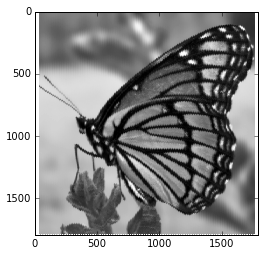

In [17]:
example_hex = hex2image(image2hex(example))
# plt.imsave("tryout.png", example_hex, cmap=cm.binary)
plt.imshow(example_hex, cmap=cm.binary)

## Spiral Architecture Hexagonal grid

Algorithm inspired from "A New Simulation of Spiral Architecture"

In [18]:
# They use a different hyperpel!

# The centered hyperpel
hyperpel = np.array([\
                [-1,4],[0,4],[1,4],[2,4],[3,4],\
                [-2,3],[-1,3], [0,3], [1,3], [2,3], [3,3], [4,3],\
                [-2,2],[-1,2], [0,2], [1,2], [2,2], [3,2], [4,2],\
                [-3,1],[-2,1],[-1,1], [0,1], [1,1], [2,1], [3,1], [4,1],[5,1],\
                [-3,0],[-2,0],[-1,0], [0,0], [1,0], [2,0], [3,0], [4,0],[5,0],\
                [-2,-1],[-1,-1], [0,-1], [1,-1], [2,-1], [3,-1], [4,-1],\
                [-2,-2],[-1,-2], [0,-2], [1,-2], [2,-2], [3,-2], [4,-2],\
                [-1,-3], [0,-3], [1,-3], [2,-3], [3,-3]])

hyperpel_sa = hyperpel - np.array([1,1])

In [19]:
# Here, given a spiral address, we return the corresponding hexagon 
# in the form row/column

def sa2hex(spiral_address):
    # Split the number in basic unit and call the auxiliary function
    # Here we reverse the order, so that the index corresponds to the 
    # decimal position
    digits = str(spiral_address)[::-1] 
    
    hex_address = np.array([0,0])
    
    for i in range(len(digits)):
        if int(digits[i])<0 or int(digits[i])>6:
            print("Invalid spiral address!")
            return 
        elif digits[i]!= '0':
            hex_address += sa2hex_aux(int(digits[i]),i)
    return hex_address
        
# This computes the row/column positions of the base cases,
# that is, in the form a*10^(zeros).
def sa2hex_aux(a, zeros):
    # Base cases
    if zeros == 0:
        if a == 0:
            return np.array([0,0])
        elif a == 1:
            return np.array([0,8])
        elif a == 2:
            return np.array([-7,4])
        elif a == 3:
            return np.array([-7,-4])
        elif a == 4:
            return np.array([0,-8])
        elif a == 5:
            return np.array([7,-4])
        elif a == 6:
            return np.array([7,4])
    
    return sa2hex_aux(a,zeros-1)+ 2*sa2hex_aux(a%6 +1,zeros-1)

In [20]:
# Computes the value of the hyperpel corresponding to the given
# spiral coordinate.

def sa_value(oversampled_image,spiral_address):
    # WORKS ONLY FOR IMAGES WITH EVEN PIXELS
    center = [(oversampled_image.shape[0])/2,(oversampled_image.shape[1])/2]
    
    # The center of the hyperpel for them is the point [1,1] for us
    hp = hyperpel_sa + sa2hex(spiral_address) + center
    val = 0.
    for i in range(56):
        val += oversampled_image[hp[i,0],hp[i,1]]
    
    return val/56

In [21]:
# Assigns the given value to the hyperpel corresponding to the given
# spiral coordinate

def sa_put_value(spiral_address, value, oversampled_image):
    # WORKS ONLY FOR IMAGES WITH EVEN PIXELS
    center = [(oversampled_image.shape[0])/2,(oversampled_image.shape[1])/2]

    hp = hyperpel_sa + sa2hex(spiral_address) + center
    for i in range(56):
        oversampled_image[hp[i,0],hp[i,1]] = value
    
    return oversampled_image
    

#### Spiral addition

In [22]:
addition_table = [
    [0,1,2,3,4,5,6],
    [1,63,15,2,0,6,64],
    [2,15,14,26,3,0,1],
    [3,2,26,25,31,4,0],
    [4,0,3,31,36,42,5],
    [5,6,0,4,42,41,53],
    [6,64,1,0,5,53,52]
]

In [23]:
# Auxiliary function to recover a vector with the
# digits of a given integer (in inverse order)

def int2intvec(a):
    digit = a%10
    vec = np.array([digit],dtype=int)
    a = (a-digit)/10
    while a!=0:
        digit = a%10
        vec = np.append(vec,int(digit))
        a = (a-digit)/10
    return vec

In [24]:
def spiral_add(a,b,mod=0):
    dig_a = int2intvec(a)
    dig_b = int2intvec(b) 
    
    if (dig_a<0).any() or (dig_a>7).any() \
      or (dig_b<0).any() or (dig_b>7).any():
        print("Invalid spiral address!")
        return
    
    if len(dig_a) == 1 and len(dig_b)==1:
        return addition_table[a][b]
    
    if len(dig_a) < len(dig_b):
        dig_a.resize(len(dig_b))
    elif len(dig_b) < len(dig_a):
        dig_b.resize(len(dig_a))
        
    res = 0
    
    for i in range(len(dig_a)):
        
        if i == len(dig_a)-1:
            res += spiral_add(dig_a[i],dig_b[i])*(10**i)
        else:
            temp = spiral_add(dig_a[i],dig_b[i])
            res += (temp%10)*(10**i)
        
            carry_on = spiral_add(dig_a[i+1],(temp - temp%10)/10)
            dig_a[i+1] = str(carry_on)
    
    if mod!=0:
        return res%mod
    
    return res

In [25]:
%%timeit
spiral_add(23,15,100)

10000 loops, best of 3: 134 µs per loop


In [26]:
%%timeit
(23 + 15)%100

10000000 loops, best of 3: 22.6 ns per loop


#### Spiral multiplication

In [27]:
multiplication_table = [
    [0,0,0,0,0,0,0],
    [0,1,2,3,4,5,6],
    [0,2,3,4,5,6,1],
    [0,3,4,5,6,1,2],
    [0,4,5,6,1,2,3],
    [0,5,6,1,2,3,4],
    [0,6,1,2,3,4,5],
]

In [28]:
def spiral_mult(a,b, mod=0):
    dig_a = int2intvec(a)
    dig_b = int2intvec(b) 
    
    if (dig_a<0).any() or (dig_a>7).any() \
      or (dig_b<0).any() or (dig_b>7).any():
        print("Invalid spiral address!")
        return
    
    sa_mult = int(0)
    
    for i in range(len(dig_b)):
        for j in range(len(dig_a)):
            temp = multiplication_table[dig_a[j]][dig_b[i]]*(10**(i+j))
            sa_mult=spiral_add(sa_mult,temp)
    
    if mod!=0:
        return sa_mult%mod
    
    return sa_mult

#### Tests

Spiral multiplication is roughly three order slower than normal multiplication

In [29]:
%%timeit
spiral_mult(435,316,100)

100 loops, best of 3: 2.02 ms per loop


In [30]:
%%timeit
435*316 & 100

10000000 loops, best of 3: 21.5 ns per loop


In [31]:
%%timeit
spiral_mult(15,10,100)

1000 loops, best of 3: 463 µs per loop


In [32]:
%%timeit
15*10 & 100

10000000 loops, best of 3: 23.7 ns per loop


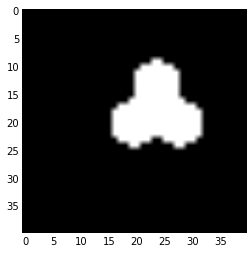

In [33]:
test = np.ones((40,40))
test = sa_put_value(0,0,ciao)
test = sa_put_value(1,0,ciao)
test = sa_put_value(2,0,ciao)
# plt.imshow(np.fft.fftshift(test),cmap=cm.binary)
plt.imshow(test,cmap=cm.binary)

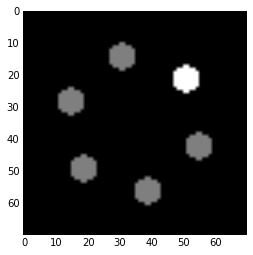

In [34]:
test = sa_put_value(10,0,np.ones((70,70)))
for i in range(2,7):
    test = sa_put_value(spiral_mult(10,i),0.5,test)
plt.imshow(test,cmap=cm.binary)

*Time to extract the values of an orbit:*

In [35]:
%%timeit
for i in range(1,7):
    sa_value(oversampled_example,spiral_mult(10,i))

1000 loops, best of 3: 1.58 ms per loop


*Time to put the values of an orbit*

In [36]:
%%timeit
test = np.ones((60,60))
for i in range(1,7):
    sa_put_value(spiral_mult(10,i),1,test)

1000 loops, best of 3: 1.54 ms per loop


*$7^5=16.807$ seems to be the biggest power of $7$ contained in a 256x256 image* (recall that in total the pixels are $256^2=65.536$)

It corresponds to spiral addresses of at most 5 digits

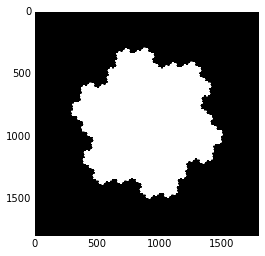

In [46]:
test = np.ones((7*256,7*256))
for i in range(7**5):
    sa_put_value(base7_encode(i),0,test)
plt.imshow(test, cmap=cm.binary)

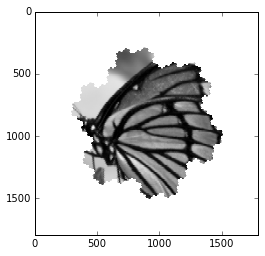

In [43]:
test = np.zeros((7*256,7*256))
for i in range(7**5):
    sa_index = base7_encode(i)
    sa_put_value(sa_index,sa_value(oversampled_example,sa_index) ,test)
plt.imshow(test, cmap=cm.binary)

### Videos

In [45]:
img = np.ones((256,256))
for i in range(7**3):
    sa_put_value(base7_encode(i),0,img)
#     plt.imshow(img, cmap=cm.binary)
    plt.imsave('_tmp%05d.png'%i, img,cmap = cm.binary) 

FPS = 10

os.system("rm movie.mp4")

os.system("ffmpeg -r "+str(FPS)+" -b 1800 -i _tmp%05d.png movie.mp4")
os.system("rm _tmp*.png")

0